# COP/USD Exchange Rate and ARIMA Model Forecasting

### Author: Shen-Han Chiu
### Date: December 12, 2024

### Dataset:
1. The datasets were downloaded from https://fred.stlouisfed.org/series/COLCCUSMA02STM and https://www.investing.com/currencies/usd-cop-historical-data using the FRED API. In this final project, I compare 2 currencies - Colombian Peso and US Dollar. The exchange rate in the dataset focused on the past two years ranging from October 10, 2022 to October 10, 2024 and it take the average of the daily exchange rates.

2. The FRED API provides the exchange rate as a ratio of the two currencies based on the value of them compared to the other. The currencies with a value greater than USD are expressed as Currency/USD and those with smaller value are expressed as USD/Currency.

Note: For deatails of this jupternotebook, please find my github page: https://github.com/DrGroove96.

In [120]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

usd_cop_data = pd.read_csv('USD_COP Historical Data.csv')
colc_cusma_data = pd.read_csv('COLCCUSMA02STM.csv')

In [121]:
colc_cusma_data.head()

,observation_date,COLCCUSMA02STM
0,2022-10-01,4726.851238
1,2022-11-01,4920.762955
2,2022-12-01,4793.102682
3,2023-01-01,4715.022773
4,2023-02-01,4822.551750


In [122]:
usd_cop_data.head()

,Date,Price,Open,High,Low,Vol.,Change %
0,12/12/2024,"4,338.00","4,338.00","4,338.00","4,338.00",NaN,0.06%
1,12/11/2024,"4,335.50","4,375.01","4,380.00","4,338.00",NaN,-0.73%
2,12/10/2024,"4,367.50","4,371.98","4,391.25","4,362.65",NaN,-0.04%
3,12/09/2024,"4,369.05","4,419.30","4,419.52","4,369.92",NaN,-0.81%
4,12/06/2024,"4,404.80","4,419.34","4,419.34","4,382.17",NaN,-0.10%


In [123]:
usd_cop_data['Date'] = pd.to_datetime(usd_cop_data['Date'], format='%m/%d/%Y')
usd_cop_data = usd_cop_data[['Date', 'Price']].sort_values(by='Date')
usd_cop_data.set_index('Date', inplace=True)
usd_cop_data = usd_cop_data.asfreq('D')
usd_cop_data['Price'] = usd_cop_data['Price'].replace(',', '', regex=True).astype(float)
usd_cop_data['Price'] = usd_cop_data['Price'].fillna(method='ffill')

colc_cusma_data['observation_date'] = pd.to_datetime(colc_cusma_data['observation_date'])
colc_cusma_data.set_index('observation_date', inplace=True)
colc_cusma_data = colc_cusma_data.asfreq('MS')

usd_cop_data.head()

<ipython-input-123-d32b62605a5f>:6: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  usd_cop_data['Price'] = usd_cop_data['Price'].fillna(method='ffill')


,Price
Date,
2024-11-11,4358.49
2024-11-12,4444.50
2024-11-13,4477.50
2024-11-14,4477.50
2024-11-15,4421.51


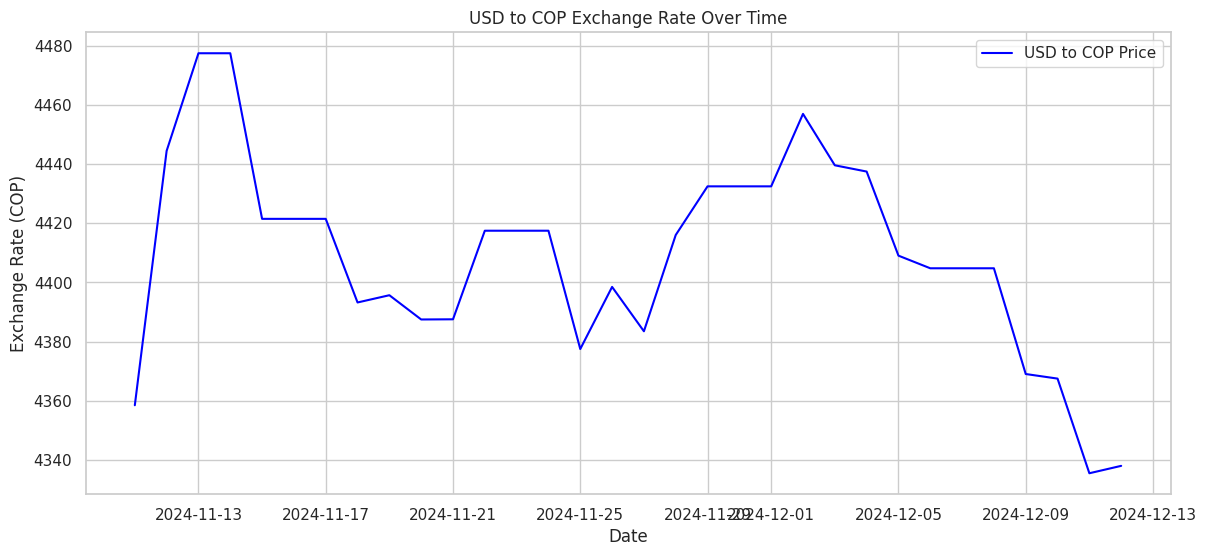

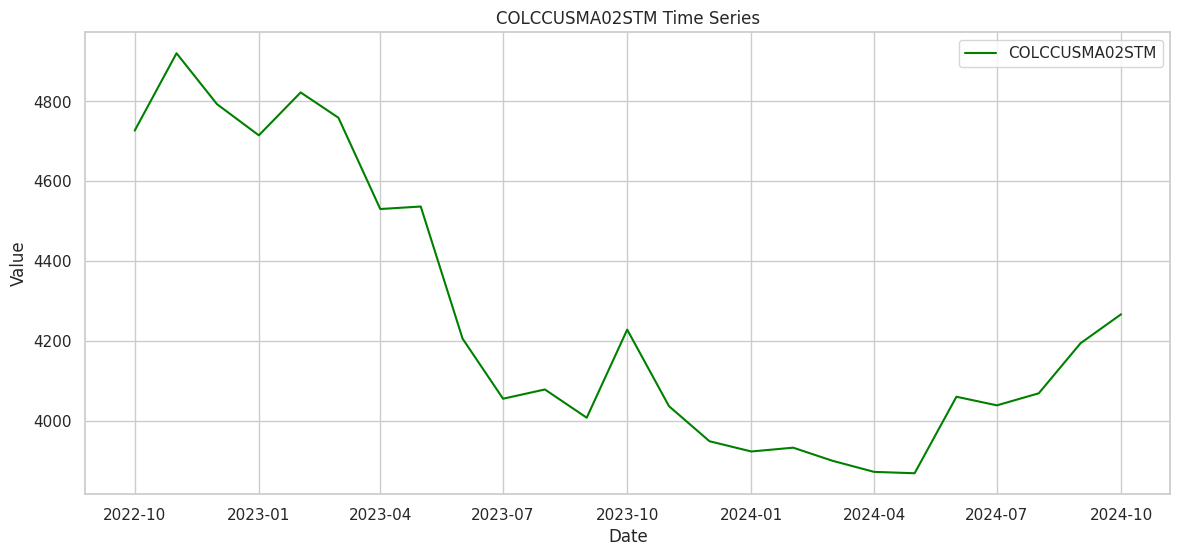

In [124]:
plt.figure(figsize=(14, 6))
plt.plot(usd_cop_data['Price'], label='USD to COP Price', color='blue')
plt.title('USD to COP Exchange Rate Over Time')
plt.xlabel('Date')
plt.ylabel('Exchange Rate (COP)')
plt.legend()
plt.show()

plt.figure(figsize=(14, 6))
plt.plot(colc_cusma_data['COLCCUSMA02STM'], label='COLCCUSMA02STM', color='green')
plt.title('COLCCUSMA02STM Time Series')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.show()

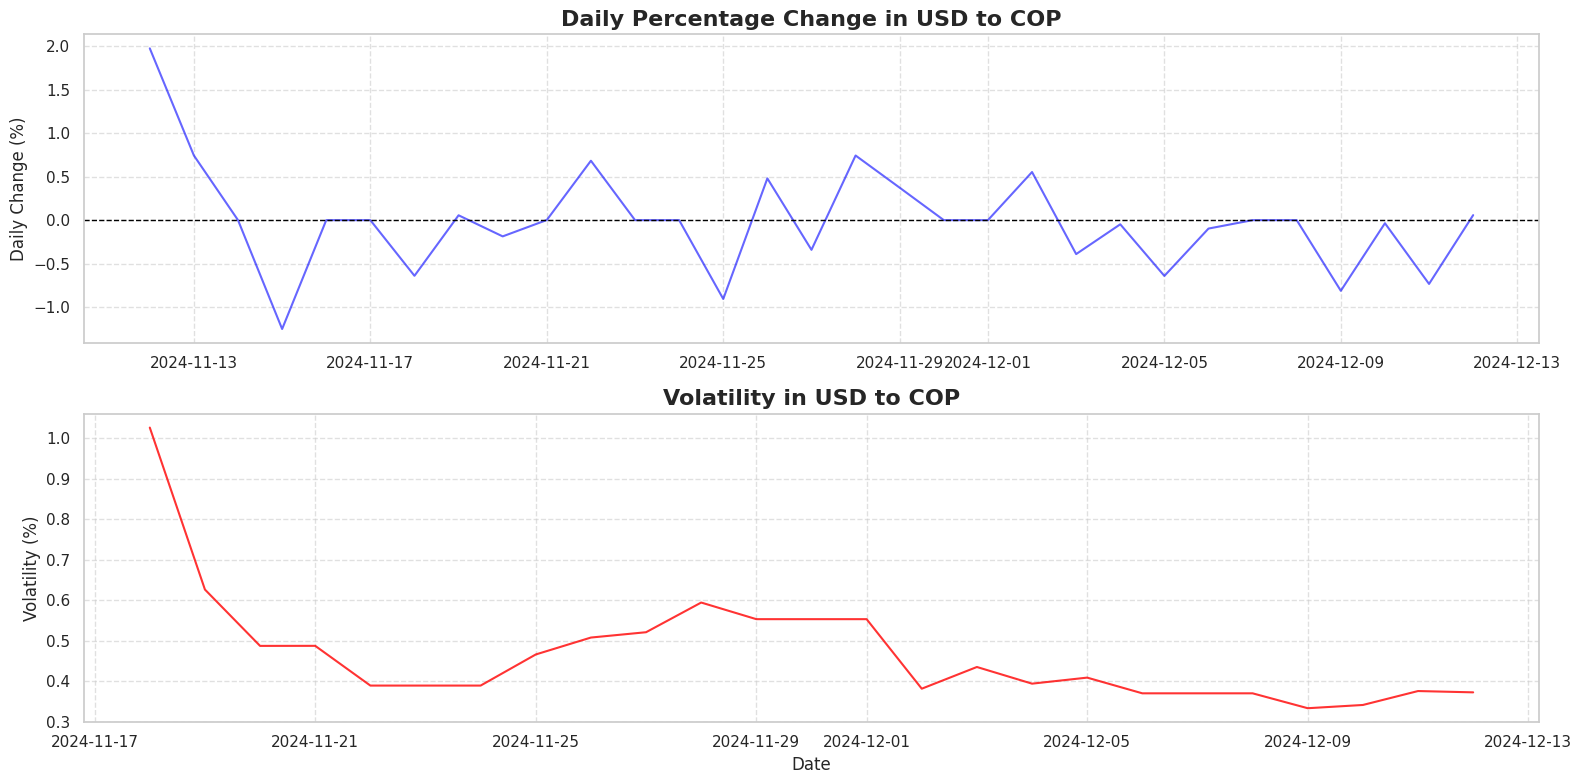

In [125]:
usd_cop_data['Daily_Change'] = usd_cop_data['Price'].pct_change() * 100
usd_cop_data['Volatility'] = usd_cop_data['Daily_Change'].rolling(window=7).std()

plt.figure(figsize=(16, 8))

plt.subplot(2, 1, 1)
plt.plot(usd_cop_data.index, usd_cop_data['Daily_Change'], color='blue', alpha=0.6)
plt.axhline(0, color='black', linestyle='--', linewidth=1)
plt.title('Daily Percentage Change in USD to COP', fontsize=16, weight='bold')
plt.ylabel('Daily Change (%)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)

plt.subplot(2, 1, 2)
plt.plot(usd_cop_data.index, usd_cop_data['Volatility'], color='red', alpha=0.8)
plt.title('Volatility in USD to COP', fontsize=16, weight='bold')
plt.ylabel('Volatility (%)', fontsize=12)
plt.xlabel('Date', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()


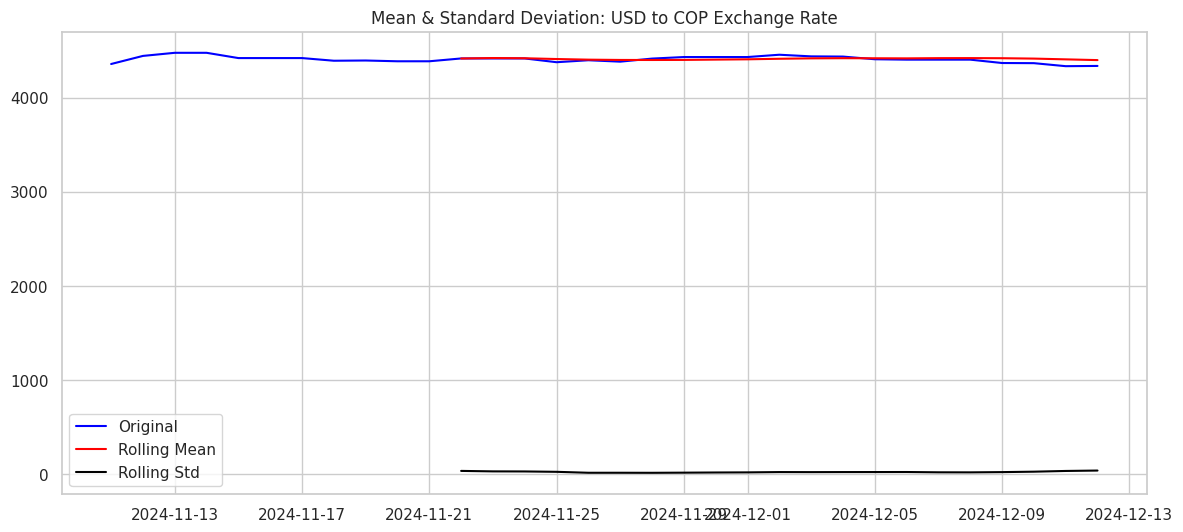

ADF Test Results for USD to COP Exchange Rate:
Test Statistic            -2.833740
p-value                    0.053614
Lags Used                 10.000000
Number of Observations    21.000000
Critical Value (1%)       -3.788386
Critical Value (5%)       -3.013098
Critical Value (10%)      -2.646397
dtype: float64




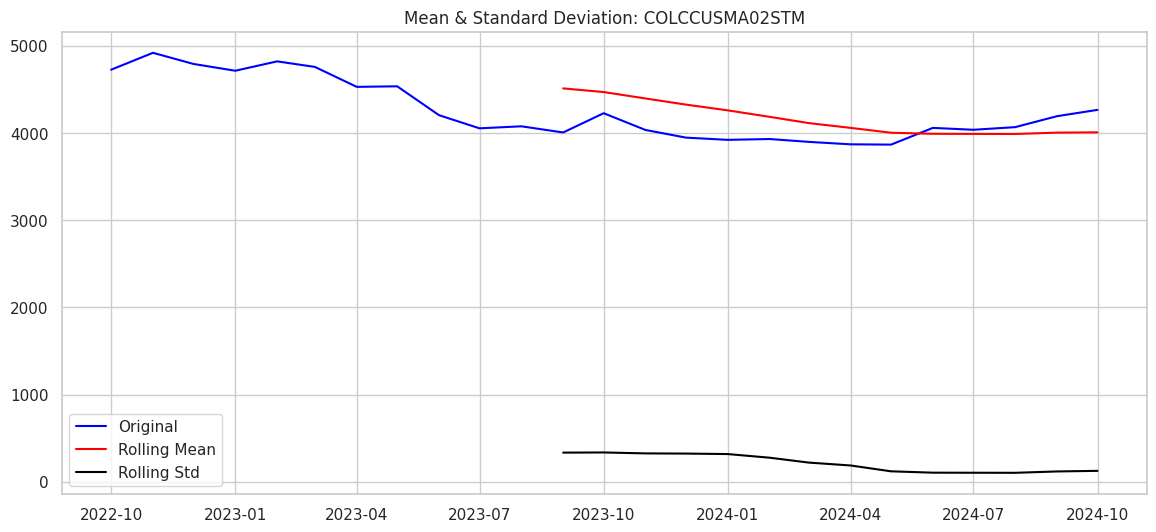

ADF Test Results for COLCCUSMA02STM:
Test Statistic             0.161915
p-value                    0.970043
Lags Used                  9.000000
Number of Observations    15.000000
Critical Value (1%)       -3.964443
Critical Value (5%)       -3.084908
Critical Value (10%)      -2.681814
dtype: float64




In [126]:
def test_stationarity(timeseries, title):
    rolling_mean = timeseries.rolling(window=12).mean()
    rolling_std = timeseries.rolling(window=12).std()

    plt.figure(figsize=(14, 6))
    plt.plot(timeseries, color='blue', label='Original')
    plt.plot(rolling_mean, color='red', label='Rolling Mean')
    plt.plot(rolling_std, color='black', label='Rolling Std')
    plt.title(f'Mean & Standard Deviation: {title}')
    plt.legend()
    plt.show()

    print(f'ADF Test Results for {title}:')
    adf_test = adfuller(timeseries.dropna())
    results = {
        "Test Statistic": adf_test[0],
        "p-value": adf_test[1],
        "Lags Used": adf_test[2],
        "Number of Observations": adf_test[3]
    }
    for key, value in adf_test[4].items():
        results[f"Critical Value ({key})"] = value
    print(pd.Series(results))
    print("\n")

test_stationarity(usd_cop_data['Price'], 'USD to COP Exchange Rate')
test_stationarity(colc_cusma_data['COLCCUSMA02STM'], 'COLCCUSMA02STM')


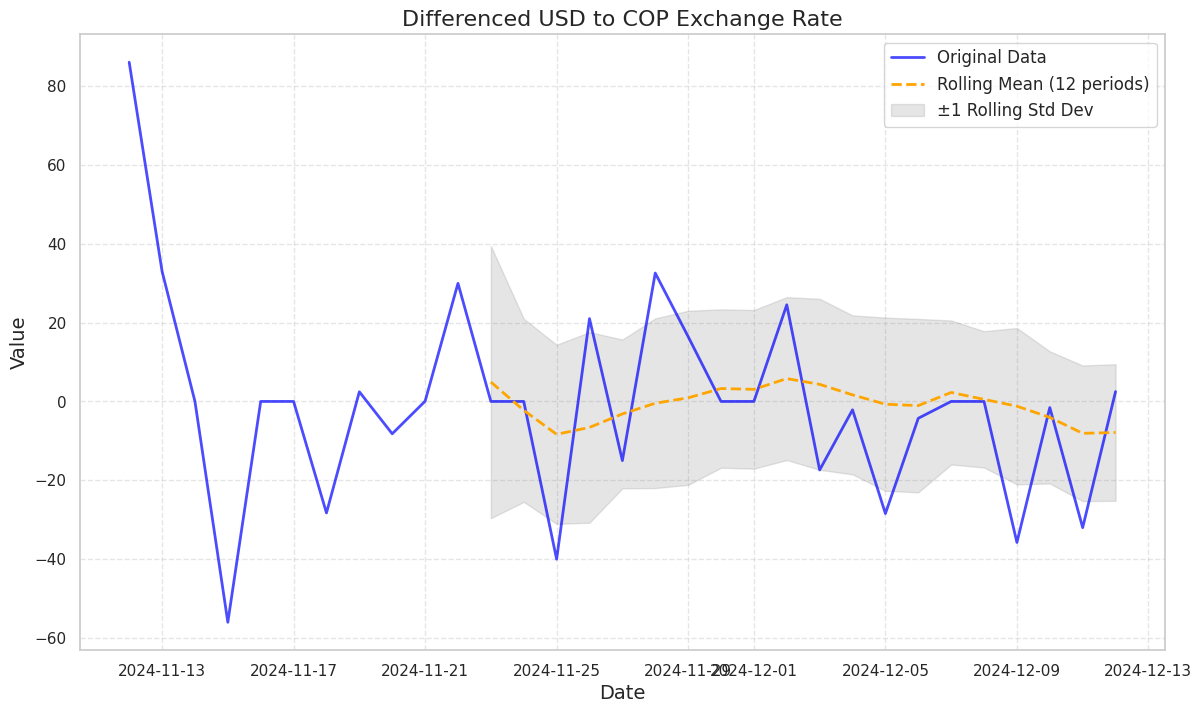

ADF Test Results for Differenced USD to COP Exchange Rate:
Test Statistic           -6.245640e+00
p-value                   4.583196e-08
Lags Used                 0.000000e+00
Number of Observations    3.000000e+01
Critical Value (1%)      -3.669920e+00
Critical Value (5%)      -2.964071e+00
Critical Value (10%)     -2.621171e+00
dtype: float64




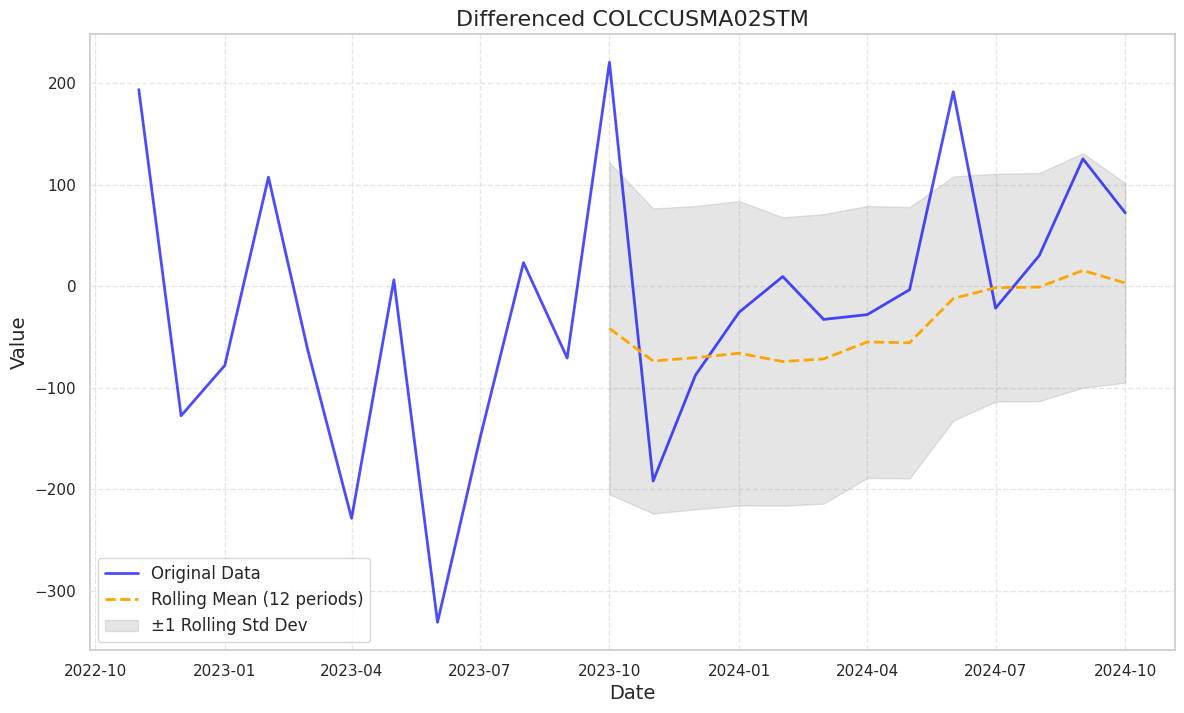

ADF Test Results for Differenced COLCCUSMA02STM:
Test Statistic             0.691998
p-value                    0.989677
Lags Used                  8.000000
Number of Observations    15.000000
Critical Value (1%)       -3.964443
Critical Value (5%)       -3.084908
Critical Value (10%)      -2.681814
dtype: float64




In [127]:
def enhanced_stationarity_test(timeseries, title):
    rolling_mean = timeseries.rolling(window=12).mean()
    rolling_std = timeseries.rolling(window=12).std()

    plt.figure(figsize=(14, 8))

    plt.plot(timeseries, color='blue', label='Original Data', linewidth=2, alpha=0.7)

    plt.plot(rolling_mean, color='orange', label='Rolling Mean (12 periods)', linewidth=2, linestyle='--')
    plt.fill_between(
        rolling_std.index,
        rolling_mean - rolling_std,
        rolling_mean + rolling_std,
        color='gray', alpha=0.2, label='±1 Rolling Std Dev'
    )

    plt.title(f'{title}', fontsize=16)
    plt.xlabel('Date', fontsize=14)
    plt.ylabel('Value', fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.show()

    print(f"ADF Test Results for {title}:")
    adf_test = adfuller(timeseries.dropna())
    results = {
        "Test Statistic": adf_test[0],
        "p-value": adf_test[1],
        "Lags Used": adf_test[2],
        "Number of Observations": adf_test[3]
    }
    for key, value in adf_test[4].items():
        results[f"Critical Value ({key})"] = value
    print(pd.Series(results))
    print("\n")

usd_cop_data['Differenced'] = usd_cop_data['Price'].diff()
enhanced_stationarity_test(usd_cop_data['Differenced'], 'Differenced USD to COP Exchange Rate')

colc_cusma_data['Differenced'] = colc_cusma_data['COLCCUSMA02STM'].diff()
enhanced_stationarity_test(colc_cusma_data['Differenced'], 'Differenced COLCCUSMA02STM')


<Figure size 1400x600 with 0 Axes>

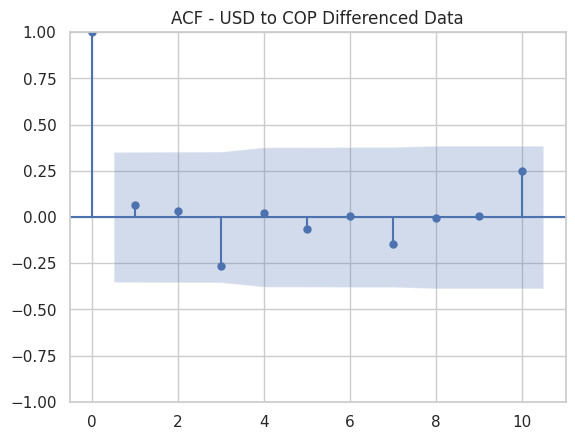

<Figure size 1400x600 with 0 Axes>

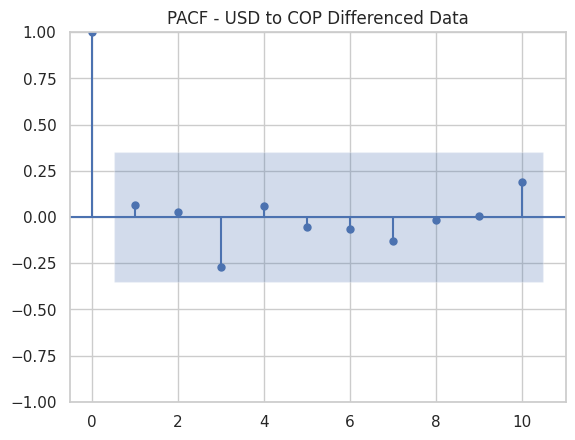

<Figure size 1400x600 with 0 Axes>

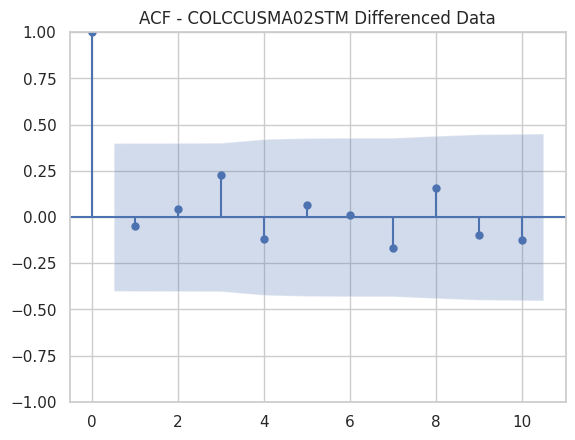

<Figure size 1400x600 with 0 Axes>

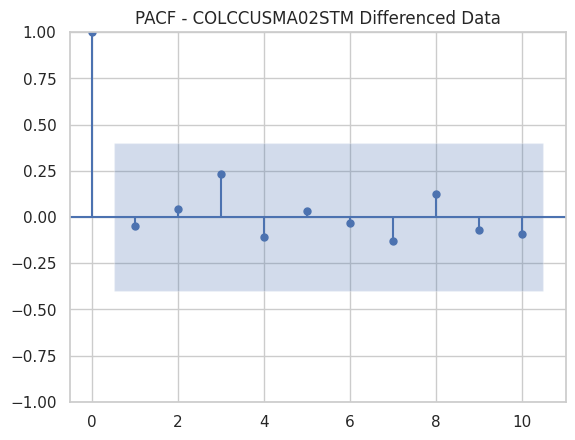

In [128]:
max_lags_usd_cop = min(10, len(usd_cop_data['Differenced'].dropna()) // 2)
max_lags_colc_cusma = min(10, len(colc_cusma_data['Differenced'].dropna()) // 2)

plt.figure(figsize=(14, 6))
plot_acf(usd_cop_data['Differenced'].dropna(), lags=max_lags_usd_cop)
plt.title('ACF - USD to COP Differenced Data')
plt.show()

plt.figure(figsize=(14, 6))
plot_pacf(usd_cop_data['Differenced'].dropna(), lags=max_lags_usd_cop)
plt.title('PACF - USD to COP Differenced Data')
plt.show()

plt.figure(figsize=(14, 6))
plot_acf(colc_cusma_data['Differenced'].dropna(), lags=max_lags_colc_cusma)
plt.title('ACF - COLCCUSMA02STM Differenced Data')
plt.show()

plt.figure(figsize=(14, 6))
plot_pacf(colc_cusma_data['Differenced'].dropna(), lags=max_lags_colc_cusma)
plt.title('PACF - COLCCUSMA02STM Differenced Data')
plt.show()

In [129]:
usd_cop_data['Log_Price'] = np.log(usd_cop_data['Price'])


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


                                     SARIMAX Results                                     
Dep. Variable:                             Price   No. Observations:                   32
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 7)   Log Likelihood                -117.269
Date:                           Thu, 12 Dec 2024   AIC                            244.538
Time:                                   09:37:43   BIC                            250.428
Sample:                               11-11-2024   HQIC                           246.101
                                    - 12-12-2024                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0642      1.650      0.039      0.969      -3.171       3.299
ma.L1          0.1427      1.631      0.088

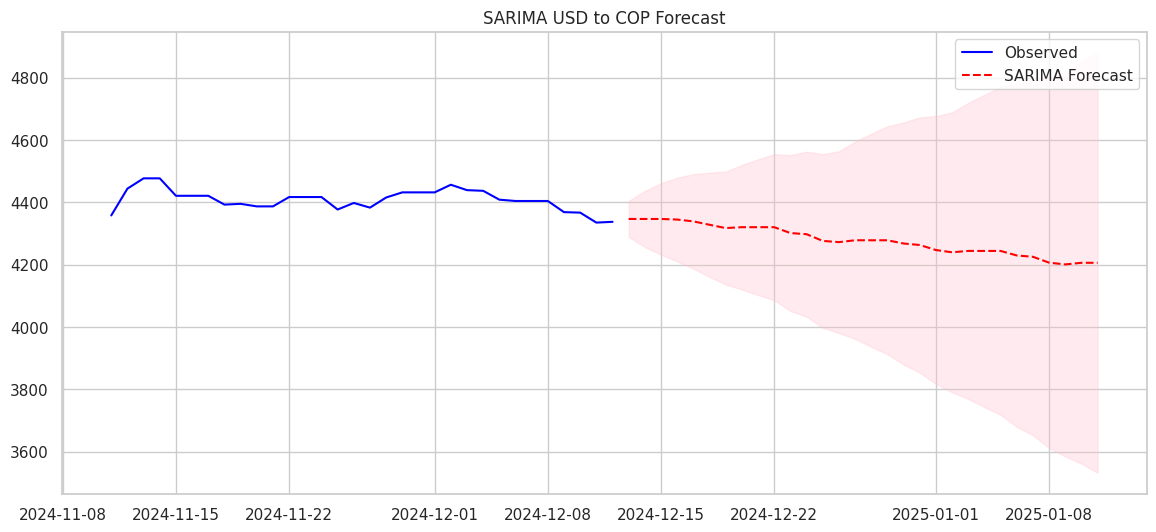

In [ ]:
sarima_model = SARIMAX(usd_cop_data['Price'], order=(1, 1, 1), seasonal_order=(1, 1, 1, 7))
sarima_result = sarima_model.fit()
print(sarima_result.summary())

# Forecast
sarima_forecast = sarima_result.get_forecast(steps=30)
sarima_forecast_ci = sarima_forecast.conf_int()

plt.figure(figsize=(14, 6))
plt.plot(usd_cop_data['Price'], label='Observed', color='blue')
plt.plot(sarima_forecast.predicted_mean, label='SARIMA Forecast', color='red', linestyle='--')
plt.fill_between(
    sarima_forecast_ci.index,
    sarima_forecast_ci.iloc[:, 0],
    sarima_forecast_ci.iloc[:, 1],
    color='pink', alpha=0.3
)
plt.title('SARIMA USD to COP Forecast')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
print(usd_cop_data.head())
print(usd_cop_data.shape)
print(usd_cop_data['Price'].dropna().shape)

In [ ]:
train = usd_cop_data['Price'][:-10]
test = usd_cop_data['Price'][-10:]

arima_train_model = ARIMA(train, order=(1, 1, 1)).fit()

test_forecast = arima_train_model.forecast(steps=len(test))

plt.figure(figsize=(12, 6))
plt.plot(test.index, test, label='Actual', color='blue')
plt.plot(test.index, test_forecast, label='Forecast', color='red', linestyle='--')
plt.title('Validation Forecast for USD to COP')
plt.xlabel('Date')
plt.ylabel('Exchange Rate')
plt.legend()
plt.grid(True)
plt.show()

rmse = np.sqrt(mean_squared_error(test, test_forecast))
print(f'RMSE: {rmse:.2f}')


In [ ]:
sns.set(style="whitegrid")

train_size = int(len(usd_cop_data) * 0.8)
train, test = usd_cop_data['Price'][:train_size], usd_cop_data['Price'][train_size:]

usd_cop_data['Differenced'] = usd_cop_data['Price'].diff()

arima_model = ARIMA(train, order=(1, 1, 1))
arima_fit = arima_model.fit()

arima_forecast = arima_fit.forecast(steps=len(test))

sarima_model = SARIMAX(train, order=(1, 1, 1), seasonal_order=(1, 1, 1, 7))
sarima_fit = sarima_model.fit()

sarima_forecast = sarima_fit.forecast(steps=len(test))

arima_mae = mean_absolute_error(test, arima_forecast)
arima_rmse = np.sqrt(mean_squared_error(test, arima_forecast))
sarima_mae = mean_absolute_error(test, sarima_forecast)
sarima_rmse = np.sqrt(mean_squared_error(test, sarima_forecast))

metrics = pd.DataFrame({
    'Model': ['ARIMA', 'SARIMA'],
    'MAE': [arima_mae, sarima_mae],
    'RMSE': [arima_rmse, sarima_rmse]
})
metrics.set_index('Model', inplace=True)

plt.figure(figsize=(14, 6))
plt.plot(train, label='Training Data', color='blue', linewidth=2)
plt.plot(test, label='Test Data', color='orange', linewidth=2)
plt.plot(test.index, arima_forecast, label='ARIMA Forecast', color='red', linestyle='--', linewidth=2)
plt.title('ARIMA Forecast - USD to COP', fontsize=16, weight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.6)
plt.show()

plt.figure(figsize=(14, 6))
plt.plot(train, label='Training Data', color='blue', linewidth=2)
plt.plot(test, label='Test Data', color='orange', linewidth=2)
plt.plot(test.index, sarima_forecast, label='SARIMA Forecast', color='green', linestyle='--', linewidth=2)
plt.title('SARIMA Forecast - USD to COP', fontsize=16, weight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.6)
plt.show()

plt.figure(figsize=(8, 4))
sns.barplot(data=metrics.reset_index(), x='Model', y='RMSE', palette='viridis')
plt.title('Model Comparison: RMSE', fontsize=14, weight='bold')
plt.xlabel('Model', fontsize=12)
plt.ylabel('RMSE', fontsize=12)
plt.show()

print(metrics)

In [ ]:
plt.figure(figsize=(14, 8))

plt.plot(train, label='Training Data', color='blue', linewidth=2)

plt.plot(test, label='Test Data', color='orange', linewidth=2)

plt.plot(test.index, arima_forecast, label='ARIMA Forecast', color='red', linestyle='--', linewidth=2)

plt.plot(test.index, sarima_forecast, label='SARIMA Forecast', color='green', linestyle='--', linewidth=2)

plt.fill_between(
    test.index,
    sarima_forecast,
    arima_forecast,
    color='gray',
    alpha=0.3,
    label='Difference Between Models'
)

plt.title('Model Comparison: ARIMA vs SARIMA Forecast - USD to COP', fontsize=16, weight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)

plt.show()
